# Notebook for testing and exploring the generalized workflow for feature extraction

In [45]:
import sys
import os
import pandas as pd
import numpy as np

module_path = os.path.abspath(os.path.join('..'))

sys.path.insert(1, module_path + '/src/utils/')
#import audio_time_series_classification as preproject
import utility

sys.path.insert(1, module_path + '/src/utils/')
import helper_dim_red as helper

from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array

import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

figure_path = module_path + '/figures/'

# Loading already extracted features

## KAGGLE

In [61]:
X_train_, y_train_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/kaggle_TRAIN.ts')
X_test_, y_test_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/kaggle_TEST.ts')
X_val_, y_val_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/kaggle_VAL.ts')

X_train_, X_test_, X_val_ = from_nested_to_2d_array(X_train_), from_nested_to_2d_array(X_test_), from_nested_to_2d_array(X_val_)

cols = np.arange(len(X_test_.columns))
X_train_.columns, X_test_.columns, X_val_.columns = cols, cols, cols

y_train_, y_test_, y_val_ = pd.Series(y_train_), pd.Series(y_test_), pd.Series(y_val_)


scaler = MinMaxScaler() 
scaler.fit(X_train_)
X_train_ = pd.DataFrame(scaler.transform(X_train_)) 
X_val_ = pd.DataFrame(scaler.transform(X_val_)) 
X_test_ = pd.DataFrame(scaler.transform(X_test_))


def get_indices_targets_kaggle(y_train_, y_test_, y_val_, classes = ['crackle', 'wheeze', 'normal']):
    # Balance dataset
    min_balance = min(list(y_train_.value_counts()))

    # Select classes
    indices = {
        'normal' : np.where(y_train_ == 'normal')[0][:min_balance],
        'wheeze' : np.where(y_train_ == 'wheeze')[0][:min_balance],
        'crackle': np.where(y_train_ == 'crackle')[0][:min_balance]
    }
    indices_train = np.concatenate([indices[c] for c in classes])
    
    
    indices = {
        'normal' : np.where(y_test_ == 'normal')[0], 
        'wheeze' : np.where(y_test_ == 'wheeze')[0],
        'crackle' : np.where(y_test_ == 'crackle')[0]
    }
    indices_test = np.concatenate([indices[c] for c in classes])
    
    
    indices = {
        'normal' : np.where(y_val_ == 'normal')[0], 
        'wheeze' : np.where(y_val_ == 'wheeze')[0],
        'crackle' : np.where(y_val_ == 'crackle')[0]
    }
    indices_val = np.concatenate([indices[c] for c in classes])
    
    
    y_train = y_train_[indices_train]
    y_test = y_test_[indices_test]
    y_val = y_val_[indices_val]
    
    return indices_train, indices_test, indices_val, y_train, y_test, y_val

indices_train_, indices_test_, indices_val_, y_train_, y_test_, y_val_ = get_indices_targets_kaggle(y_train_,
                                                                                       y_test_, y_val_,
                                                                                       classes = ['crackle', 'wheeze', 'normal'])

## UIT

In [9]:
X_train, y_train_o = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_allLabels_scilence_2_5s_TRAIN.ts')
X_test, y_test_o = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_allLabels_scilence_2_5s_TEST.ts')
X_val, y_val_o = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_allLabels_scilence_2_5s_VAL.ts')
X_train, y_train_o = shuffle(X_train, y_train_o, random_state = 42)


X_train, X_test, X_val = from_nested_to_2d_array(X_train), from_nested_to_2d_array(X_test), from_nested_to_2d_array(X_val)

cols = np.arange(len(X_test.columns))
X_train.columns, X_test.columns, X_val.columns = cols, cols, cols

y_train_o, y_test_o, y_val_o = pd.Series(y_train_o), pd.Series(y_test_o), pd.Series(y_val_o)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train)) 
X_val = pd.DataFrame(scaler.transform(X_val)) 
X_test = pd.DataFrame(scaler.transform(X_test)) 

#### Subclass classification

In [50]:
def get_indices_targets(y_train_o, y_test_o, y_val_o, classes = ['crackle', 'wheeze', 'normal']):
    # Go from 5 to 3 classes
    y_train_new = y_train_o.copy(deep = True)
    
    y_train_new[y_train_new == 'exp_wheeze'] = 'wheeze'
    y_train_new[y_train_new == 'insp_wheeze'] = 'wheeze'
    y_train_new[y_train_new == 'exp_crackle'] = 'crackle'
    y_train_new[y_train_new == 'insp_crackle'] = 'crackle'

    y_test_new = y_test_o.copy(deep = True)

    y_test_new[y_test_new == 'exp_wheeze'] = 'wheeze'
    y_test_new[y_test_new == 'insp_wheeze'] = 'wheeze'
    y_test_new[y_test_new == 'exp_crackle'] = 'crackle'
    y_test_new[y_test_new == 'insp_crackle'] = 'crackle'

    y_val_new = y_val_o.copy(deep = True)

    y_val_new[y_val_new == 'exp_wheeze'] = 'wheeze'
    y_val_new[y_val_new == 'insp_wheeze'] = 'wheeze'
    y_val_new[y_val_new == 'exp_crackle'] = 'crackle'
    y_val_new[y_val_new == 'insp_crackle'] = 'crackle'
    
    # Balance dataset
    min_balance = min(list(y_train_new.value_counts()))

    # Select classes
    indices = {
        'normal' : np.where(y_train_new == 'normal')[0][:min_balance],
        'wheeze' : np.where(y_train_new == 'wheeze')[0][:min_balance],
        'crackle': np.where(y_train_new == 'crackle')[0][:min_balance]
    }
    indices_train = np.concatenate([indices[c] for c in classes])
    
    
    indices = {
        'normal' : np.where(y_test_new == 'normal')[0], 
        'wheeze' : np.where(y_test_new == 'wheeze')[0],
        'crackle' : np.where(y_test_new == 'crackle')[0]
    }
    indices_test = np.concatenate([indices[c] for c in classes])
    
    
    indices = {
        'normal' : np.where(y_val_new == 'normal')[0], 
        'wheeze' : np.where(y_val_new == 'wheeze')[0],
        'crackle' : np.where(y_val_new == 'crackle')[0]
    }
    indices_val = np.concatenate([indices[c] for c in classes])
    
    
    y_train = y_train_new[indices_train]
    y_test = y_test_new[indices_test]
    y_val = y_val_new[indices_val]
    
    return indices_train, indices_test, indices_val, y_train, y_test, y_val

indices_train, indices_test, indices_val, y_train, y_test, y_val = get_indices_targets(y_train_o,
                                                                                       y_test_o, y_val_o,
                                                                                       classes = ['crackle', 'wheeze', 'normal'])

## Combining Kaggle and UiT

In [64]:
y_val_c = pd.concat([y_val, y_val_])
X_val_c = pd.concat([X_val.iloc[indices_val], X_val_.iloc[indices_val_]])

y_test_c = pd.concat([y_test, y_test_])
X_test_c = pd.concat([X_test.iloc[indices_test], X_test_.iloc[indices_test_]])

y_train_c = pd.concat([y_train, y_train_])
X_train_c = pd.concat([X_train.iloc[indices_train], X_train_.iloc[indices_train_]])

scaler = MinMaxScaler() 
scaler.fit(X_train_c)
X_train_c = pd.DataFrame(scaler.transform(X_train_c)) 
X_test_c = pd.DataFrame(scaler.transform(X_test_c)) 
X_val_c = pd.DataFrame(scaler.transform(X_val_c)) 

### Plotting PCR

**PLSR plot of the tromsø data**

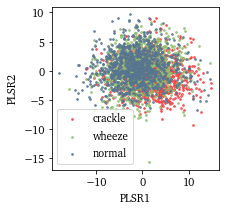

In [65]:
y_train_f = pd.factorize(y_train)

pls2 = PLSRegression(n_components=2)
p2 = pls2.fit_transform(X_train.iloc[indices_train], y_train_f[0])
f, ax = helper.scatterplot_with_colors(p2[0], y_train_f[0],
                                       module_path, new_legends = list(y_train_f[1]),
                                       x_y_labels = ['PLSR1', 'PLSR2'])

plt.show()

f.savefig(figure_path + f'comparing_kaggle_uit/PLSR_uit.pdf', bbox_inches='tight')

**PLSR plot of Kaggle dataset**

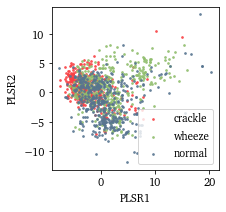

In [67]:
y_train_f = pd.factorize(y_train_)

pls2 = PLSRegression(n_components=2)
p2 = pls2.fit_transform(X_train_.iloc[indices_train_], y_train_f[0])
f, ax = helper.scatterplot_with_colors(p2[0], y_train_f[0],
                                       module_path, new_legends = list(y_train_f[1]),
                                       x_y_labels = ['PLSR1', 'PLSR2'])

plt.show()

f.savefig(figure_path + f'comparing_kaggle_uit/PLSR_kaggle.pdf', bbox_inches='tight')

**PLSR plot when combining the two datasets**

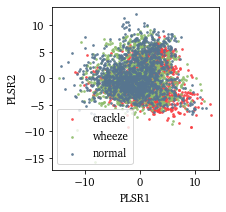

In [68]:
y_train_f = pd.factorize(y_train_c)

pls2 = PLSRegression(n_components=2)
p2 = pls2.fit_transform(X_train_c, y_train_f[0])
f, ax = helper.scatterplot_with_colors(p2[0], y_train_f[0],
                                       module_path, new_legends = list(y_train_f[1]),
                                       x_y_labels = ['PLSR1', 'PLSR2'])


plt.show()
f.savefig(figure_path + f'comparing_kaggle_uit/PLSR_combined.pdf', bbox_inches='tight')

# Classification using RFC

### UIT dataset

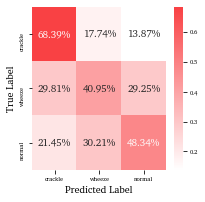

In [69]:
from sklearn.ensemble import RandomForestClassifier

class_names =  list(pd.factorize(y_train)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)


clf.fit(X_train.iloc[indices_train] , y_train)
y_pred = clf.predict(X_test.iloc[indices_test])

f, ax = utility.plot_cm(y_test , y_pred, module_path = module_path, class_names = class_names)

f.savefig(figure_path + f'comparing_kaggle_uit/cm_uit.pdf', bbox_inches='tight')

### Kaggle Dataset

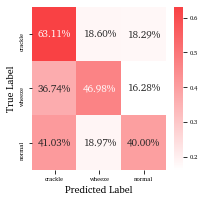

In [71]:
class_names =  list(pd.factorize(y_train_)[1])

clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)

clf.fit(X_train_.iloc[indices_train_] , y_train_)
y_pred = clf.predict(X_val_.iloc[indices_val_])

f, ax = utility.plot_cm(y_val_, y_pred, module_path = module_path, class_names = class_names)


f.savefig(figure_path + f'comparing_kaggle_uit/cm_kaggle.pdf', bbox_inches='tight')

**Combination of the two datasets**

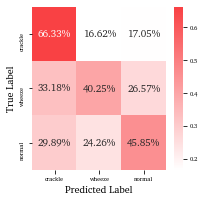

In [72]:
class_names =  list(pd.factorize(y_train_)[1])

clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)

clf.fit(X_train_c , y_train_c)
y_pred = clf.predict(X_val_c)

f, ax = utility.plot_cm(y_val_c , y_pred, module_path = module_path, class_names = class_names)

f.savefig(figure_path + f'comparing_kaggle_uit/cm_combined.pdf', bbox_inches='tight')

### Train on UiT data, test on Kaggle Data

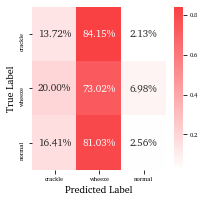

In [73]:
class_names =  list(pd.factorize(y_train)[1])

clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)

clf.fit(X_train.iloc[indices_train] , y_train )

y_pred = clf.predict(X_val_.iloc[indices_val_])

f, ax = utility.plot_cm(y_val_ , y_pred, module_path = module_path, class_names = class_names)

f.savefig(figure_path + f'comparing_kaggle_uit/cm_train_uit_test_kaggle.pdf', bbox_inches='tight')

### Train on UiT + Kaggle, and test on Kaggle data

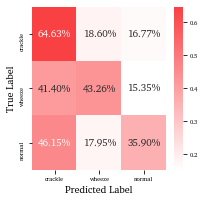

In [74]:
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)

clf.fit(X_train_c, y_train_c )

y_pred = clf.predict(X_val_.iloc[indices_val_])

f, ax = utility.plot_cm(y_val_ , y_pred, module_path = module_path, class_names = class_names)

f.savefig(figure_path + f'comparing_kaggle_uit/cm_combined_test_kaggle.pdf', bbox_inches='tight')